## Прогнозирование временных рядов

## Постановка задачи

**Прогнозирование** - оценка будущих значений ряда на основе его прошлого

Горизонт прогнозирования (`H`). `H` - на сколько шагов вперёд нужен прогноз (например, 7 дней). Чем больше `H`, тем выше неопределённость

Одношаговый или многошаговый прогноз - предсказываем следующий шаг (`t +1`) или сразу несколько (`t+1`, ... `t+H`).

Форма прогноза: предсказательный интервал или точечные реализации

Стоит посмотреть: [Data Mining in Action Лекция 10 Прогнозирование временных рядов](https://youtu.be/u433nrxdf5k?si=h2lgje8reb6W32Kd)

Бенчмарк для временных рядов: [pytsbe](https://github.com/ITMO-NSS-team/pytsbe)


In [2]:
import random
import numpy as np
import pandas as pd
from datetime import timedelta
import matplotlib.pyplot as plt

SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
rng = np.random.default_rng(SEED)  

In [3]:
start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)
t = np.arange(n)

noise_component_scale = 0.1
noise_values = np.random.normal(0, noise_component_scale, n)

In [4]:
def get_ts_with_season():
    # Let's simulate week seasonality
    m = 7
    values = np.sin(2 * np.pi * t / m) + noise_values
    return values

ts_with_season = get_ts_with_season()

## Модели для прогнозирования временных рядов

Самая простая модель, которая есть, это повторение последнего известного значения

Следующая - прогноз как среднее исторических значений ряда

Потом сглаживания, например экспоненциальное

Но есть и посложнее

### AR

In [27]:
from statsmodels.tsa.ar_model import AutoReg
from ipywidgets import interact, IntSlider

forecast_horizon = 5
y = pd.Series(ts_with_season, index=datetime_index, name="y")

def fit_and_plot_ar(lag: int):
    # Fit AR(lag) model
    model = AutoReg(y, lags=lag, old_names=False)
    result = model.fit()

    # Forecast next forecast_horizon steps
    future_index = pd.date_range(
        start=y.index[-1] + pd.tseries.frequencies.to_offset(freq),
        periods=forecast_horizon,
        freq=freq
    )
    forecast_values = result.forecast(steps=forecast_horizon)
    forecast_series = pd.Series(forecast_values, index=future_index, name="forecast")

    # Plot observed data and forecast (single plot, no explicit colors)
    plt.figure(figsize=(8, 4))
    plt.plot(y.index, y.values, label="observed")
    plt.plot(forecast_series.index, forecast_series.values, label="forecast", linestyle="--", marker="o")
    plt.axvline(y.index[-1], linestyle=":", c='black', label="forecast start")
    plt.legend()
    plt.ylim(-2, 2)
    plt.grid(alpha=0.2)
    plt.title(f"AR({lag}) - {forecast_horizon}-step ahead forecast")
    plt.tight_layout()
    plt.show()

    # Print parameters and forecast table
    print(f"AR({lag}) parameters:")
    print(result.params.to_string())

interact(
    fit_and_plot_ar,
    lag=IntSlider(value=2, min=2, max=10, step=1, description="AR lags")
);

interactive(children=(IntSlider(value=2, description='AR lags', max=10, min=2), Output()), _dom_classes=('widg…

Модель строить мы научились, но как проверить качество? 

Построим прогноз для участка ряда, где значения известны

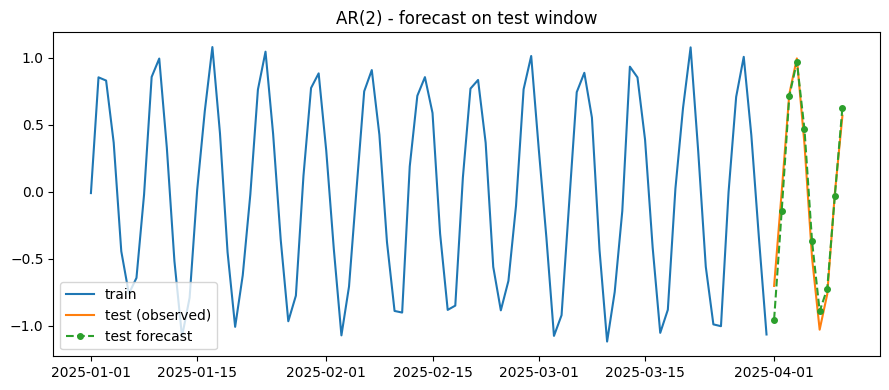

In [71]:
def make_ar_model_and_plot_with_validation(forecast_horizon: int, lag_order: int):
    y = pd.Series(ts_with_season, index=datetime_index, name="y")
    split_point = len(y) - forecast_horizon
    y_train = y.iloc[:split_point]
    y_test = y.iloc[split_point:]
    
    model = AutoReg(y_train, lags=lag_order, old_names=False)
    result = model.fit()
    
    y_test_pred_values = result.forecast(steps=forecast_horizon)
    
    y_test_forecast = pd.Series(y_test_pred_values, index=y_test.index, name="forecast")
    
    plt.figure(figsize=(9, 4))
    plt.plot(y_train.index, y_train.values, label="train")
    plt.plot(y_test.index, y_test.values, label="test (observed)")
    plt.plot(y_test_forecast.index, y_test_forecast.values, linestyle="--", marker="o", markersize=4, label="test forecast")
    plt.title(f"AR({lag_order}) - forecast on test window")
    plt.legend()
    plt.tight_layout()
    plt.show()

forecast_horizon = 10
lag_order = 2
make_ar_model_and_plot_with_validation(forecast_horizon, lag_order)

## Метрики 

Классические регрессионные метрики

In [68]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error, \
    mean_absolute_percentage_error


def symmetric_mean_absolute_percentage_error(actual, predicted):
    """ Function to calculate SMAPE metric """

    actual = np.array(actual)
    predicted = np.array(predicted)
    denominator = (np.abs(actual) + np.abs(predicted)) / 2
    non_zero = denominator != 0

    smape = np.zeros_like(actual, dtype=float)
    smape[non_zero] = np.abs(predicted[non_zero] - actual[non_zero]) / denominator[non_zero]
    return 100 * np.mean(smape)


mae_value = mean_absolute_error(y_test.values, y_test_forecast.values)
print(f"MAE {mae_value:.2f}")

smape_value = symmetric_mean_absolute_percentage_error(y_test.values, y_test_forecast.values)
print(f"SMAPE {smape_value:.2f}, %")

MAE 0.09
SMAPE 41.17, %


Главное, понимать специфику:

<img src="../data/how_can_we_quantify_similarity_between_time_series.png" alt="Time series dataset" width="700">

© [How can we quantify similarity between time series?](https://medium.com/gorillatech/how-can-we-quantify-similarity-between-time-series-ed1d0b633ca0)

## Валидация

Длина ряда - 100 элементов, а метрика посчитана на последних 10, что составляет всего 10%.
Что делать если хочется увеличить размер выборки до 20% или 30%.

### Подход 1. Увеличить горизонт прогнозирования

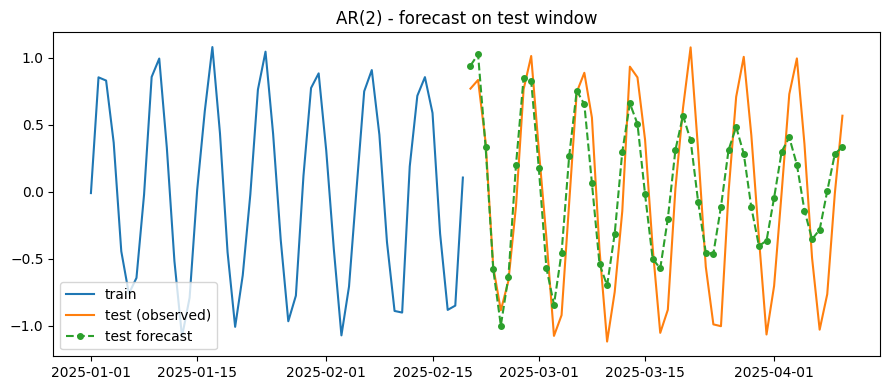

In [74]:
make_ar_model_and_plot_with_validation(forecast_horizon*5, lag_order)

Но есть две проблемы: 

- Не все модели на временных рядах строят прогнозы рекурсивно как AR, то есть для таких forecast_horizon должен быть фиксирован 
- Поскольку авторегрессионные модели используют предсказания как предикторы для следующей итерации, неопределенность предсказаний накапливается 

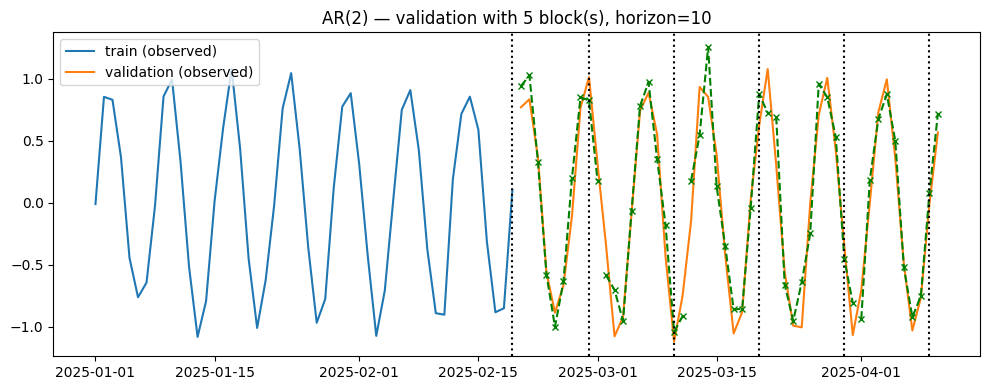

In [84]:
def make_ar_model_and_plot_with_validation(
    forecast_horizon: int,
    lag_order: int,
    validation_blocks: int
):
    y = pd.Series(ts_with_season, index=datetime_index, name="y")

    total_points = len(y)
    validation_length = validation_blocks * forecast_horizon
    train_end_index = total_points - validation_length

    # Split into train and validation tail
    y_train = y.iloc[:train_end_index]
    y_valid = y.iloc[train_end_index:]

    # Fit AR(lag_order) on training data
    model = AutoReg(y_train, lags=lag_order, old_names=False)
    result = model.fit()

    params = result.params
    intercept = float(params.get("const", 0.0))
    ar_coefs = [float(params.get(f"y.L{j}", 0.0)) for j in range(1, lag_order + 1)]

    block_forecasts = {}

    block1_start = train_end_index
    block1_end = train_end_index + forecast_horizon  # exclusive slice end
    block1_index = y.index[block1_start:block1_end]

    block1_values = result.forecast(steps=forecast_horizon)
    block_forecasts[1] = pd.Series(block1_values, index=block1_index, name="forecast_block_1")

    for b in range(2, validation_blocks + 1):
        start_idx = train_end_index + (b - 1) * forecast_horizon
        end_idx_exclusive = train_end_index + b * forecast_horizon
        block_index = y.index[start_idx:end_idx_exclusive]

        preds = []
        for t_pos in range(start_idx, end_idx_exclusive):
            y_hat = intercept
            for j in range(1, lag_order + 1):
                y_hat += ar_coefs[j - 1] * y.iloc[t_pos - j]
            preds.append(y_hat)

        block_forecasts[b] = pd.Series(preds, index=block_index, name=f"forecast_block_{b}")

    plt.figure(figsize=(10, 4))
    plt.plot(y_train.index, y_train.values, label="train (observed)")
    plt.plot(y_valid.index, y_valid.values, label="validation (observed)")

    for b, series_b in block_forecasts.items():
        style = "--"
        marker = "x"
        plt.plot(series_b.index, series_b.values, linestyle=style, marker=marker,
                 markersize=4, c="green")
        plt.axvline(series_b.index[-2], linestyle=":", c='black')
    plt.axvline(y_train.index[-1], linestyle=":", c='black')
    plt.title(f"AR({lag_order}) — validation with {validation_blocks} block(s), horizon={forecast_horizon}")
    plt.legend()
    plt.tight_layout()
    plt.show()

make_ar_model_and_plot_with_validation(forecast_horizon, lag_order, validation_blocks=5)

Подытожим про валидацию

<img src="../data/forecast_validation.gif" alt="Time series dataset" width="700">


Теперь вернемся к моделям

## MA (moving average), ARMA, ARIMA, pmdarima

In [88]:
import numpy as np


def moving_average_forecast(series, window_size: int, forecast_horizon: int):
    values = np.asarray(series, dtype=float)
    if window_size <= 0 or forecast_horizon <= 0:
        raise ValueError("window_size and forecast_horizon must be positive integers.")

    history = values.copy()
    forecasts = []
    for _ in range(forecast_horizon):
        window = history[-window_size:] if history.size >= window_size else history
        next_value = float(window.mean())
        forecasts.append(next_value)
        history = np.append(history, next_value)
    return np.array(forecasts)


y = pd.Series(ts_with_season, index=datetime_index, name="y")
moving_average_forecast(y, window_size=20, forecast_horizon=10)

array([-0.0933372 , -0.11323533, -0.090926  , -0.04600184,  0.00184799,
        0.00202983, -0.03331208, -0.08539011, -0.11081149, -0.09915365])

Осталось доделать 

- MA, ARMA, ARIMA и автоматическая настройка с помощью pmdarima
- Прогнозирование с помощью FEDOT
- AutoTS

Про секцию с фреймворками:
- Разбор современных фреймворков (насколько легко устанавливать, как запустить расчет, есть ли возможность распараллеливания вычислений, 
 предусмотрена ли возможность передачи кастомной метрики, можно ли остановить оптимизацию на каком-либо этапе и потом ее продолжить,
 как модели можно сериализовать (сохранять) а потом загружать в память и использовать для предсказаний, если есть docker образ, то насколько он большой и так далее)
- Общие рекомендации (Dockerflie, лицензия, совместимость с вашей текущей инфраструктурой, насколько хорошо библиотека поддерживается и так далее)